# Import

In [ ]:
!pip install transformers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chat Frequency over Time

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_chat_data.csv')
df.head()

In [18]:
def plot_messages(dataframe, frequency):
    # Resample and count messages
    resampled_data = dataframe.resample(frequency, on='Timestamp').count()

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get current axis
    resampled_data['Content'].plot(kind='bar', ax=ax)

    # Manually setting x-tick labels
    if frequency in ['D', 'W', 'M']:
        ax.set_xticks(range(len(resampled_data)))
        ax.set_xticklabels([date.strftime('%Y-%m-%d') if frequency in ['D', 'W']
                            else date.strftime('%Y-%m')
                            for date in resampled_data.index])

    # Rotate and align the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.title(f'Number of Messages Sent Over Time ({frequency})')
    plt.xlabel('Time')
    plt.ylabel('Number of Messages')
    plt.tight_layout()
    plt.show()


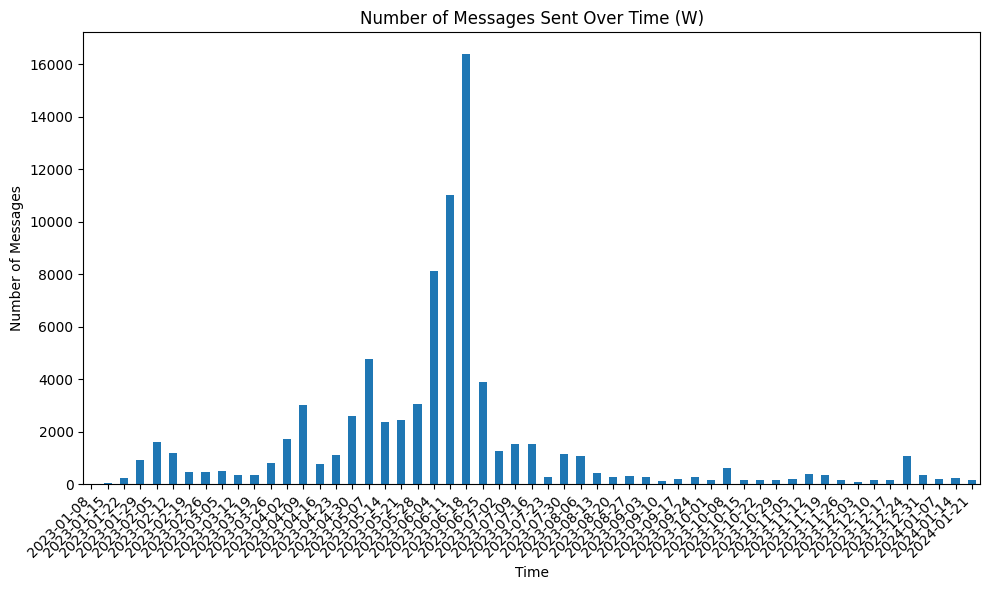

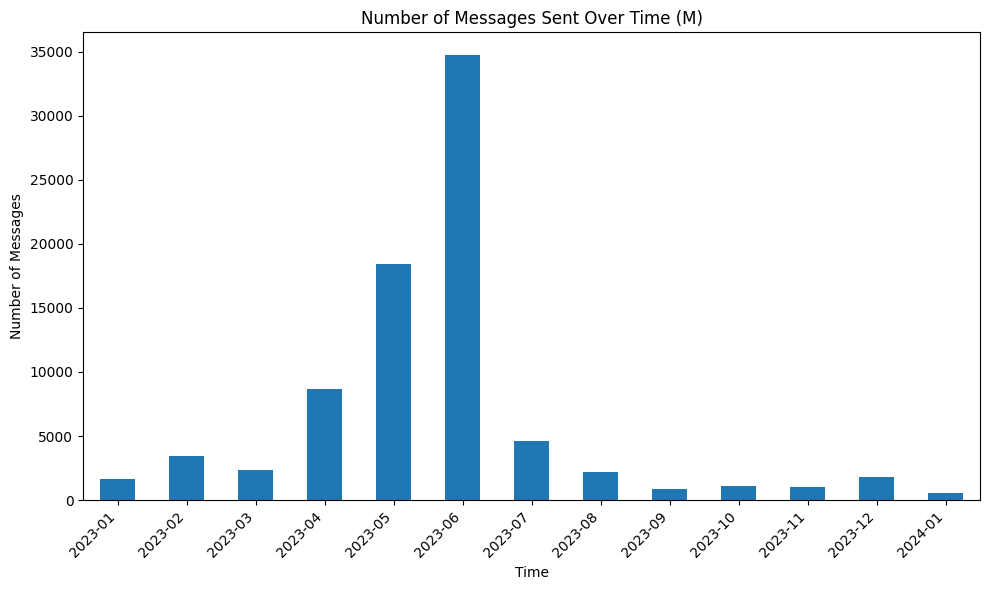

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M')

# plot_messages(df, 'D')  # for daily
plot_messages(df, 'W')  # for weekly
plot_messages(df, 'M')  # for monthly

# Sentiment Analysis

In [3]:
from transformers import pipeline

In [7]:
sentiment_pipeline = pipeline(model="WhitePeak/bert-base-cased-Korean-sentiment")
sentiment_pipeline(" ")

[{'label': 'LABEL_0', 'score': 0.9970788955688477}]